In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
from spacy import displacy
from sklearn.metrics.pairwise import linear_kernel


In [2]:
# read csv files
dataset = pd.read_csv('/kaggle/input/dataset/Dataset.csv')
movie_title = pd.read_csv('/kaggle/input/dataset/Movie_Id_Titles.csv')

In [3]:
# sample of data
print('dataset :')
print(dataset.head(2))
print('titles :')
print(movie_title.head(2))


dataset :
   user_id  item_id  rating  timestamp
0        0       50       5  881250949
1        0      172       5  881250949
titles :
   item_id             title
0        1  Toy Story (1995)
1        2  GoldenEye (1995)


In [4]:
data = pd.merge(dataset,movie_title , on = 'item_id')

In [5]:
# sample of data
data.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


In [6]:
# data shape
data.shape

(100003, 5)

In [7]:
len(data['user_id'].value_counts())

944

In [8]:
# how many movies in system
len(data['title'].unique())

1664

In [9]:
# rating range
max = data['rating'].max()
min = data['rating'].min()
print(f'high rating = {max} , low rating = {min}')

high rating = 5 , low rating = 1


In [10]:
# get rating count
data_rating = dict(data['rating'].value_counts())
data_rating

{4: 34174, 3: 27145, 5: 21203, 2: 11370, 1: 6111}

<Axes: title={'center': 'Rating Count'}>

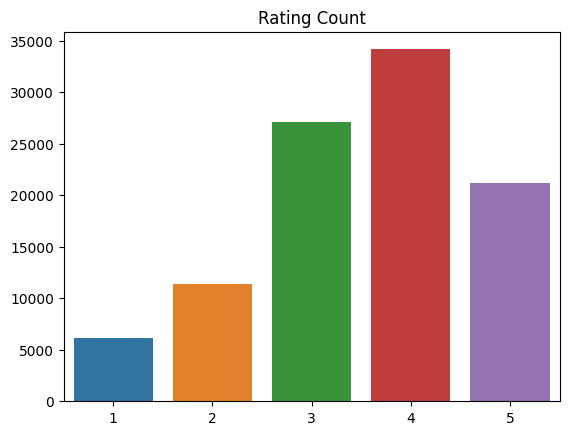

In [11]:
# visualize rating
plt.title('Rating Count')
sns.barplot(x = list(data_rating.keys()), y = list(data_rating.values()))

In [12]:
# get rating average
average_rating = dict()
count_rating = dict()
for title in data['title'].unique():
  average_rating[title] = data[data['title'] == title]['rating'].mean()
  count_rating[title]  = data[data['title'] == title]['rating'].count()
tmp_average = np.zeros((data.shape[0]))
tmp_count  = np.zeros((data.shape[0]))
for idx in range(data.shape[0]):
  tmp_average[idx]  = average_rating[data['title'][idx]]
  tmp_count[idx] = count_rating[data['title'][idx]]
data['average_rating'] = tmp_average
data['count_rating'] = tmp_count
data.head(2)

,user_id,item_id,rating,timestamp,title,average_rating,count_rating
0,0,50,5,881250949,Star Wars (1977),4.359589,584.0
1,290,50,5,880473582,Star Wars (1977),4.359589,584.0


In [13]:
# Simple Recommendation
C = data['average_rating'].mean()
M = data['count_rating'].quantile(0.90)

In [14]:
Q_movies = data.copy().loc[data['count_rating'] >=M] # place qualified data beacuse we want top of them
Q_movies.shape

(10127, 7)

In [15]:
# Function that computes the weighted rating of each movie
def weighted_rating(x, M=M, C=C):
    v = x['count_rating']
    R = x['average_rating']
    # Calculation based on the IMDB formula
    return (v/(v+M) * R) + (M/(M+v) * C)

In [16]:
Q_movies['score'] = Q_movies.apply(weighted_rating , axis = 1)
Q_movies = Q_movies.sort_values('score' , ascending = False)

In [17]:
Q_movies['title'].unique()[:15] # recommended movies

array(['Star Wars (1977)', 'Godfather, The (1972)',
       'Silence of the Lambs, The (1991)',
       'Raiders of the Lost Ark (1981)', 'Fargo (1996)', 'Titanic (1997)',
       'Empire Strikes Back, The (1980)', 'Return of the Jedi (1983)',
       'Pulp Fiction (1994)', 'Fugitive, The (1993)', 'Toy Story (1995)',
       'Contact (1997)', 'Chasing Amy (1997)',
       'Back to the Future (1985)', 'Twelve Monkeys (1995)'], dtype=object)

In [18]:
# how many movies in new dataset after filtering
len(Q_movies['title'].unique())

24

<Axes: title={'center': 'Top 15 Movies'}, ylabel='title'>

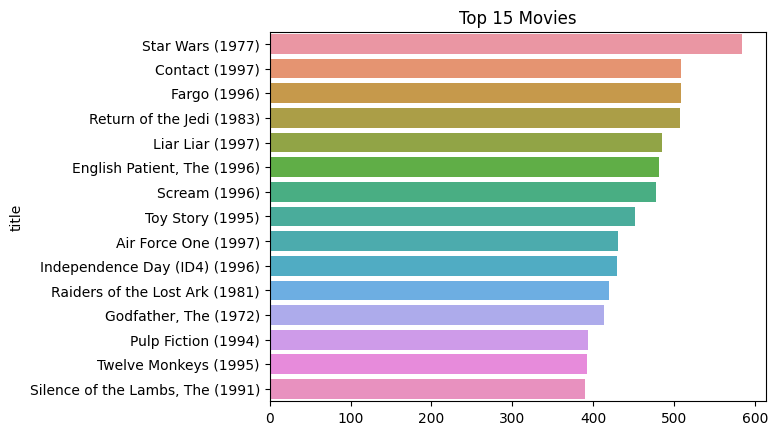

In [19]:
tmp_d = Q_movies['title'].value_counts()
plt.title('Top 15 Movies')
sns.barplot(y=tmp_d.keys()[:15], x=tmp_d.values[:15])

<Axes: title={'center': 'Count Movies'}>

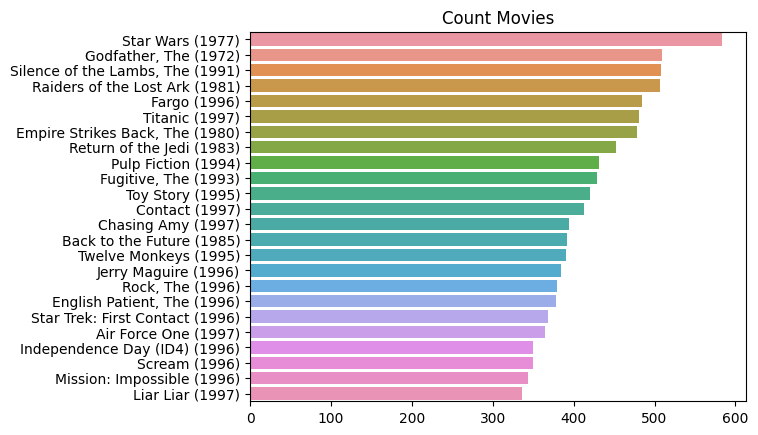

In [20]:
plt.title('Count Movies')
sns.barplot(y = list(Q_movies['title'].unique()) , x = list(Q_movies['title'].value_counts()))

In [21]:
movie_rate = data.pivot_table(index = 'user_id' ,columns = 'title' , values ='rating')
movie_rate.fillna(0 , inplace = True)

In [22]:
movie_rate.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,2.0,5.0,0.0,0.0,3.0,4.0,0.0,0.0,...,0.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
df = pd.DataFrame()
df['count_rating'] = pd.DataFrame(data.groupby('title')['rating'].count())

In [24]:
df.head()

,count_rating
title,
'Til There Was You (1997),9
1-900 (1994),5
101 Dalmatians (1996),109
12 Angry Men (1957),125
187 (1997),41


In [25]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title , min_rating_count = 50):

    user_rating = movie_rate[title]

    similar_movies = movie_rate.corrwith(user_rating)

    corr_movies = pd.DataFrame(similar_movies , columns = ['correlations'])

    corr_movies.dropna(inplace = True)

    corr_movies = corr_movies.join(df['count_rating'], how='left', lsuffix='_left', rsuffix='_right')

    final = corr_movies[corr_movies['count_rating'] > min_rating_count].sort_values('correlations' , ascending = False)

    return final

In [26]:
recommended = get_recommendations('Year of the Horse (1997)')
recommended.head(10)

,correlations,count_rating
title,,
Money Talks (1997),0.235931,92
Sirens (1994),0.187562,59
Deconstructing Harry (1997),0.154465,65
In the Company of Men (1997),0.137049,66
Enchanted April (1991),0.134486,70
Ulee's Gold (1997),0.132283,184
Kull the Conqueror (1997),0.131986,69
"Apostle, The (1997)",0.129643,55
How to Make an American Quilt (1995),0.123879,71


<Axes: title={'center': 'Best 10 Movies For Year of the Horse Movie'}>

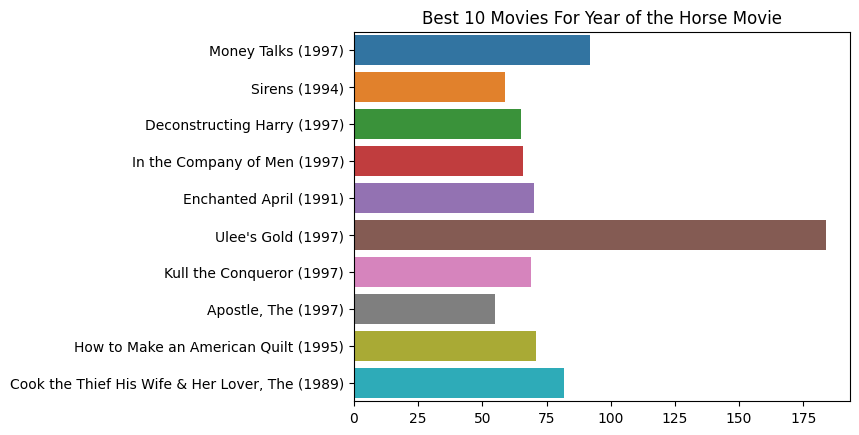

In [27]:
plt.title('Best 10 Movies For Year of the Horse Movie')
sns.barplot(y = list(recommended.index)[:10] , x = list(recommended['count_rating'])[:10])